In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import fbeta_score, make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings('ignore')

RSEED = 50

In [2]:
df = pd.read_csv("Home_Loan/application_train.csv.tar.gz")

In [3]:
# Splitting the data with stratifying due imbalanced data
df.dropna(subset=["TARGET"], inplace=True)
y = df.pop("TARGET")
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state = RSEED)

In [4]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

def clean_data(X, y, test=True):
    global mm_scaler, std_scaler
    
    df = pd.concat([X, y], axis=1)
    
    # Drop rows where target value is missing
    df.dropna(subset=["TARGET"], inplace=True)
    
    # Drop rows where important monetary values are missing
    df.dropna(subset=["AMT_INCOME_TOTAL", "AMT_CREDIT",
                      "AMT_ANNUITY", "AMT_GOODS_PRICE"],
              inplace=True)
    
    # Drop outliers
    if not test:
        idx = np.all(stats.zscore(df[["AMT_INCOME_TOTAL", "AMT_CREDIT",
                                      "AMT_ANNUITY", "AMT_GOODS_PRICE"]]) < 3, axis=1)
        df = df[idx]
    
    # Drop outlier from "DAYS_EMPLOYED" and the "SOCIAL_CIRCLE" columns
    df.drop(index=df[df["DAYS_EMPLOYED"] >= 50000].index, inplace=True)
    df.drop(index=df[df["OBS_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_30_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["OBS_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    df.drop(index=df[df["DEF_60_CNT_SOCIAL_CIRCLE"] >= 100].index, inplace=True)
    
    # Create list y with target values
    y = df["TARGET"].astype("int").astype("category")
    
    # Create DataFrame X for all features
    X = pd.DataFrame()
    
    # Copy already correct columns
    X["REGION_POPULATION_RELATIVE"] = df["REGION_POPULATION_RELATIVE"]
    
    # Convert data types
    X["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].replace(["Y", "N"], [1, 0]).astype("int")
    X["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].replace(["Y", "N"], [1, 0]).astype("int")
    X["REG_REGION_NOT_LIVE_REGION"] = df["REG_REGION_NOT_LIVE_REGION"].astype("int")
    X["REG_REGION_NOT_WORK_REGION"] = df["REG_REGION_NOT_WORK_REGION"].astype("int")
    X["LIVE_REGION_NOT_WORK_REGION"] = df["LIVE_REGION_NOT_WORK_REGION"].astype("int")
    X["REG_CITY_NOT_LIVE_CITY"] = df["REG_CITY_NOT_LIVE_CITY"].astype("int")
    X["REG_CITY_NOT_WORK_CITY"] = df["REG_CITY_NOT_WORK_CITY"].astype("int")
    X["FLAG_DOCUMENT_2"] = df["FLAG_DOCUMENT_2"].astype("int")
    X["FLAG_DOCUMENT_3"] = df["FLAG_DOCUMENT_3"].astype("int")
    X["FLAG_DOCUMENT_4"] = df["FLAG_DOCUMENT_4"].astype("int")
    X["FLAG_DOCUMENT_5"] = df["FLAG_DOCUMENT_5"].astype("int")
    X["FLAG_DOCUMENT_6"] = df["FLAG_DOCUMENT_6"].astype("int")
    X["FLAG_DOCUMENT_7"] = df["FLAG_DOCUMENT_7"].astype("int")
    X["FLAG_DOCUMENT_8"] = df["FLAG_DOCUMENT_8"].astype("int")
    X["FLAG_DOCUMENT_9"] = df["FLAG_DOCUMENT_9"].astype("int")
    X["FLAG_DOCUMENT_10"] = df["FLAG_DOCUMENT_10"].astype("int")
    X["FLAG_DOCUMENT_11"] = df["FLAG_DOCUMENT_11"].astype("int")
    X["FLAG_DOCUMENT_12"] = df["FLAG_DOCUMENT_12"].astype("int")
    X["FLAG_DOCUMENT_13"] = df["FLAG_DOCUMENT_13"].astype("int")
    X["FLAG_DOCUMENT_14"] = df["FLAG_DOCUMENT_14"].astype("int")
    X["FLAG_DOCUMENT_15"] = df["FLAG_DOCUMENT_15"].astype("int")
    X["FLAG_DOCUMENT_16"] = df["FLAG_DOCUMENT_16"].astype("int")
    X["FLAG_DOCUMENT_17"] = df["FLAG_DOCUMENT_17"].astype("int")
    X["FLAG_DOCUMENT_18"] = df["FLAG_DOCUMENT_18"].astype("int")
    X["FLAG_DOCUMENT_19"] = df["FLAG_DOCUMENT_19"].astype("int")
    X["FLAG_DOCUMENT_20"] = df["FLAG_DOCUMENT_20"].astype("int")
    X["FLAG_DOCUMENT_21"] = df["FLAG_DOCUMENT_21"].astype("int")
    
    # Create dummy variables for categorical columns
    X = pd.concat([X, pd.get_dummies(df[["NAME_CONTRACT_TYPE", "CODE_GENDER", "NAME_TYPE_SUITE",
                                         "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                                         "NAME_HOUSING_TYPE", "ORGANIZATION_TYPE"]],
                                     drop_first=True)],  axis=1)
    
    # Filling all NaNs with mean values
    col_names = df.loc[:, "EXT_SOURCE_1" : "NONLIVINGAREA_MEDI"].columns
    X[col_names] = df[col_names].fillna(value=df[col_names].median())
    X["TOTALAREA_MODE"] = df["TOTALAREA_MODE"].fillna(value=df["TOTALAREA_MODE"].median())
    
    social_circle = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                     "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
    X[social_circle] = df[social_circle].fillna(value=df[social_circle].median())
    
    enquiries = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY",
                 "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                 "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
    X[enquiries] = df[enquiries].fillna(value=df[enquiries].median())    
    
    # Making time span variables positive
    timespanes = ["DAYS_BIRTH", "DAYS_EMPLOYED",
                 "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
    X[timespanes] = df[timespanes] * -1
    
    # Use Scaler
    std_scaled = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY",
                  "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY"]
    X["CNT_CHILDREN"] = df["CNT_CHILDREN"]
    mm_scaled = ["CNT_CHILDREN", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION",
                 "DAYS_ID_PUBLISH", "OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE",
                 "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "AMT_REQ_CREDIT_BUREAU_HOUR",
                 "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON",
                 "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
        
    if test:
        X[std_scaled] = std_scaler.transform(df[std_scaled])
        X[mm_scaled] = mm_scaler.transform(X[mm_scaled])
    else:
        X[std_scaled] = std_scaler.fit_transform(df[std_scaled])
        X[mm_scaled] = mm_scaler.fit_transform(X[mm_scaled])
    
    return X, y

In [5]:
X, y = clean_data(X_train, y_train, test=False)

In [6]:
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [8]:
# 20 features without floating, accuracy: ['REGION_POPULATION_RELATIVE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'EXT_SOURCE_2', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']
# 20 features with floating, beta-2: ['REGION_POPULATION_RELATIVE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'NAME_FAMILY_STATUS_Married', 'EXT_SOURCE_2', 'DAYS_BIRTH']
# 1-20 features with floating, accuracy: ['NAME_FAMILY_STATUS_Married', 'EXT_SOURCE_2', 'DAYS_BIRTH']
# 1-25 features with floating, beta-2: ['NAME_FAMILY_STATUS_Married', 'EXT_SOURCE_2', 'DAYS_BIRTH']

In [10]:
# Sequential Forward Floating Selection (sffs)
sffs = SFS(estimator=DecisionTreeClassifier(),
           k_features=(20),
           forward=True,
           floating=True,
           verbose=2,
           scoring=ftwo_scorer,
           cv=0,
           n_jobs=-1)

sffs.fit(X, y)

sffs.k_feature_names_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 178 out of 178 | elapsed:    5.4s finished

[2020-11-04 12:20:03] Features: 1/20 -- score: 0.5022838120306572[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 177 out of 177 | elapsed:   33.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished

[2020-11-04 12:20:38] Features: 2/20 -- score: 0.9998895302272917[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 146 tasks    

('REGION_POPULATION_RELATIVE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'NAME_FAMILY_STATUS_Married',
 'EXT_SOURCE_2',
 'DAYS_BIRTH')

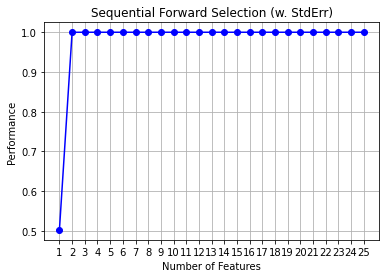

In [9]:
fig = plot_sfs(sffs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()